  # CLASSIFICAÇÃO DE ESTRELAS COM DADOS DO GAIA.

# Introdução

Este notebook tem como finalidade a classificação de estrelas usando dados do telescópio espacial GAIA, utilizando técnicas de aprendizado semi-supervisionado. Os dados principais foram obtidos do próprio banco de dados SQL do telescópio (https://gea.esac.esa.int/archive/), enquanto os adicionais, de distância, foram buscados também em linguagem SQL, mas dessa vez usando python.
  
O projeto consiste em:

-> 1-Importação e Instalação das bibliotecas;

-> 2-Aquisição dos Dados;

-> 3-Tratamento dos Dados;

-> 4-Análise Exploratória;

-> 5-Preparação dos Modelos;

-> 6-Aplicação dos Modelos;

-> 7-Ajuste dos modelos;

-> 8-Resultados;

-> 9-Conclusão. 

------------------------------------------------------------------------------------------------------------------------------

# 1 - IMPORTANDO AS BIBLIOTECAS.

In [1]:
# Principais bibliotecas.
import pandas as pd
import numpy as np

#Bibliotecas de Visualização.
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits import mplot3d
import matplotlib.gridspec as gridspec
from yellowbrick.cluster import silhouette_visualizer, KElbowVisualizer
from pandas.plotting import radviz
import rfpimp

#Bibliotecas de busca.
from astroquery.gaia import Gaia

#Bibliotecas de Machine Learning.
from sklearn.utils import resample
from scipy.stats import normaltest
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans, OPTICS, cluster_optics_dbscan
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn import metrics
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram

-----------------------------------------------------------------------------------------------------------------------------

# 2 - AQUISIÇÃO DOS DADOS.

Os dados podem ser obtidos através de uma busca no banco de dados SQL do telescópio, que pode ser acessado via astroquery (módulo do pacote astropy), ou diretamente do site da base de dados do GAIA.

## 1.1 - Dados das Observações do GAIA.

A aquisição dos dados principais do GAIA foi feita através de uma busca no banco de dados SQL do próprio telescópio espacial (https://gea.esac.esa.int/archive/), buscando os melhores resultados limitando a uma parallax de 5x10^(-3) segundos de arco, que equilave a uma distância máxima de 652 anos luz. 

                                                              👇
<img src='busca_sql.png'>

## 2.2 - Dados Complementares (Distância).

As informações de distância estão na tabela 'external.gaiaedr3_distance', e será acessado via astroquery.

In [34]:
# Acessando a tabela com as informações sobre a distância.

table_metadata1 = Gaia.load_table('external.gaiaedr3_distance')
print(table_metadata1)

Retrieving table 'external.gaiaedr3_distance'
TAP Table name: external.external.gaiaedr3_distance
Description: 
Bailer-Jones et al. (2021) EDR3 distances. <p> Estimating distances from parallaxes. V: Geometric and photogeometric distances to 1.47 billion stars in Gaia Early Data Release 3.
Bailer-Jones et al. 2021 AJ 161 147. Data replicated from gedr3dist.main table at GAVO Data Center TAP service https://dc.g-vo.org/tap and TAP metadata as of December 2020.
<p>
    Original table description.
<p>
    We estimate the distance from the Sun to sources in Gaia EDR3 that have
    parallaxes. We provide two types of distance estimate, together with
    their corresponding asymmetric uncertainties, using Bayesian posterior
    density functions that we sample for each source. Our prior is based
    on a detailed model of the 3D spatial, colour, and magnitude
    distribution of stars in our Galaxy that includes a 3D map of
    interstellar extinction.
<p>
    The first type of distance esti

In [35]:
# Verificando as colunas nas tabela 'external.gaiaedr3_distance'.

for column in table_metadata1.columns:
    print(column.name)

source_id
r_med_geo
r_lo_geo
r_hi_geo
r_med_photogeo
r_lo_photogeo
r_hi_photogeo
flag


Vemos que a tabela possui várias colunas. Estamos interessados na distância geométrica (r_med_geo) e no Identificador (source_id), para fundirmos com a outra base de dados. A busca será feita com a query na próxima célula.

In [36]:
# Query para a busca dos dados de distância limitando a uma distância de 200 Parsecs.

query1 = """SELECT TOP 100000
source_id, r_med_geo 
FROM external.gaiaedr3_distance
WHERE (external.gaiaedr3_distance.r_med_geo<200)"""

In [37]:
# Busca dos dados.

job1 = Gaia.launch_job(query1)
job1

In [38]:
# Informações da busca.

print(job1)

<Table length=100000>
   name    dtype  unit                                           description                                          
--------- ------- ---- -----------------------------------------------------------------------------------------------
source_id   int64      Unique source identifier. Note that this *cannot* be matched against the DR1 or DR2 source_ids.
r_med_geo float32   pc                The median of the geometric distance posterior. The geometric distance estimate.
Jobid: None
Phase: COMPLETED
Owner: None
Output file: 1643505448374O-result.vot.gz
Results: None


Já podemos ver que a unidade de distância é parsec, e que o tipo é float, enquanto o tipo do id é int.

In [39]:
# Verificando se o resultado está em uma tabela astropy.

results1 = job1.get_results()
type(results1)

astropy.table.table.Table

In [40]:
# Visualizando os resultados.

results1

source_id,r_med_geo
,pc
int64,float32
5853498713190525696,1.3019114
4472832130942575872,1.8281064
3864972938605115520,2.4083583
762815470562110464,2.5459516
2947050466531873024,2.670147
5140693571158946048,2.67459
5140693571158739840,2.718584
4075141768785646848,2.9754312


## 2.3 - Dados Simulados (Rotulados).

dizer como foram baixados

## 2.3 - Construindo o Dataset.

Nessa seção vamos fundir as duas tabelas de dados criando um dataset completo.

In [41]:
#Carregando os dados do GAIA em um dataframe.

GAIA = pd.read_csv('star_classification.csv')
GAIA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1865726 entries, 0 to 1865725
Data columns (total 25 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0   designation                   object 
 1   ref_epoch                     float64
 2   ra                            float64
 3   dec                           float64
 4   parallax                      float64
 5   pm                            float64
 6   astrometric_excess_noise      float64
 7   nu_eff_used_in_astrometry     float64
 8   pseudocolour                  float64
 9   visibility_periods_used       int64  
 10  phot_g_mean_flux_over_error   float64
 11  phot_g_mean_mag               float64
 12  phot_bp_mean_flux_over_error  float64
 13  phot_bp_mean_mag              float64
 14  phot_rp_mean_flux_over_error  float64
 15  phot_rp_mean_mag              float64
 16  phot_proc_mode                float64
 17  bp_rp                         float64
 18  bp_g                  

In [42]:
#Carregando os dados rotulados em um dataframe.

gaia_model = pd.read_csv('gaia_model-result.csv')
gaia_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   source_id             100000 non-null  int64  
 1   ra                    100000 non-null  float64
 2   dec                   100000 non-null  float64
 3   barycentric_distance  100000 non-null  float64
 4   mag_g                 100000 non-null  float64
 5   mag_bp                100000 non-null  float64
 6   mag_rp                100000 non-null  float64
 7   teff                  76950 non-null   float64
 8   spectral_type         76950 non-null   object 
 9   logg                  76950 non-null   float64
 10  feh                   100000 non-null  float64
dtypes: float64(9), int64(1), object(1)
memory usage: 8.4+ MB


In [43]:
# Transformando as tabelas astropy das informações de distância em dataframe.

stars_distance = pd.DataFrame()
stars_distance['id'] = results1['source_id']
stars_distance['distance'] = results1['r_med_geo']
stars_distance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   id        100000 non-null  int64  
 1   distance  100000 non-null  float32
dtypes: float32(1), int64(1)
memory usage: 1.1 MB


Os ids estão em int64, e para que seja possível fundir com o DataFrame GAIA precisamos trandformá-los em str.

In [44]:
# Renomeando a coluna designation do GAIA.

GAIA = GAIA.rename(columns={'designation': 'id', 'phot_g_mean_mag' : 'mag_g', 'phot_bp_mean_mag' : 'mag_bp',
                            'phot_rp_mean_mag' : 'mag_rp', 'dr2_rv_template_teff' : 'teff', 'dr2_rv_template_logg' : 'logg',
                            'dr2_rv_template_fe_h' : 'feh'})
gaia_model = gaia_model.rename(columns={'source_id': 'id', 'barycentric_distance': 'distance' })

# Removendo as os caracteres 'Gaia EDR3 ' do ID para fundir com outros dataframes.

GAIA.replace({'Gaia EDR3 ': ''}, regex=True, inplace=True)

# Transformando os ids em strings

stars_distance['id'] = stars_distance['id'].astype(str)
GAIA['id'] = GAIA['id'].astype(str)
gaia_model['id'] = gaia_model['id'].astype(str)

# Fundindo os dois DataFrames

stars_data = pd.merge(stars_distance, GAIA, how = 'inner', on = 'id')


# 03 - TRATAMENTO DOS DADOS.

No tratamento de dados vamos estudar se há dados faltantes, imputando valores se for viável, eliminar dados ruins passando alguns filtros, organizar nossa base de dados eliminando atributos desnecessários, e criar novos atributos úteis.

In [45]:
# Verificando se existe dados duplicados.

stars_data.duplicated(subset = ['id']).sum()

0

## 3.1 - Filtragem dos Dados.

### 3.1.1 - Balanceamento das Classes.

As classes nos dados simulados refletem a proporção das classes de estrelas da universo, logo, estão desbalanceadas. Temos muitas dados de estrelas tipo K e M, e poucas do tipo  B, nessa seção vamos balanceá-las. Também não temos nenhuma das raríssimas estrelas tipo O, o que não faz diferença pro universo local, mas é possível expandir o projeto para abranger esse tipo de estrelas com dados de algumas delas.

In [47]:
gaia_model.head(5)

,id,ra,dec,distance,mag_g,mag_bp,mag_rp,teff,spectral_type,logg,feh
0,2244097369794674750,295.968537,28.639476,11240.6120,15.947157,17.250795,14.790595,3935.5007,K6II,1.400,-0.302262
1,2244097369794674751,295.968030,28.650385,11418.7820,22.051373,22.818035,21.154085,5675.4463,G2.5V,4.485,-0.166929
2,2244097369794674758,295.962983,28.634661,2850.1487,19.639666,20.344963,18.789732,4742.4200,K2.5V,4.617,-0.232348
3,2244097369794674759,295.976284,28.629056,3225.6810,18.621939,19.174047,17.889220,5546.2573,G4V,4.516,0.151751
4,2244097369794674760,295.970567,28.640175,3246.5703,19.620127,20.287243,18.797724,4954.5020,K1.5V,4.589,0.007879


Os tipos espectrais estão misturados com o tipo de luminosidade na mesma coluna, precisamos separar isso.

In [48]:
# Separando os tipos espectrais e de luminosidade em tabelas diferentes.

gaia_model['luminosity_type'] = gaia_model['spectral_type'].str[2:]
gaia_model['spectral_type']   = gaia_model['spectral_type'].str[:1]

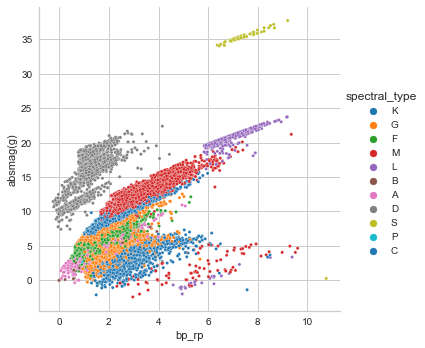

In [49]:
# Plotagem do diagrama HR com os dados simulados.

gaia_model['absmag(g)'] = gaia_model['mag_g']+5-(5*np.log10(gaia_model['distance']))
gaia_model['bp_rp'] = gaia_model['mag_bp'] - gaia_model['mag_rp']


sns.relplot(
    data=gaia_model,
    x='bp_rp', y="absmag(g)",
    hue='spectral_type',palette='tab10',s=10
)

Nesse gráfico fica bem visível o deslanceamento das classes. Algumas também podem ser excluídas por serem apenas subclasses das classes principais.

In [50]:
# Exclui as classes desnecessárias.

gaia_model = gaia_model.drop(gaia_model.loc[gaia_model['spectral_type']=='S'].index)
gaia_model = gaia_model.drop(gaia_model.loc[gaia_model['spectral_type']=='L'].index)
gaia_model = gaia_model.drop(gaia_model.loc[gaia_model['spectral_type']=='P'].index)
gaia_model = gaia_model.drop(gaia_model.loc[gaia_model['spectral_type']=='C'].index)
gaia_model = gaia_model.drop(gaia_model.loc[gaia_model['spectral_type']=='C'].index)

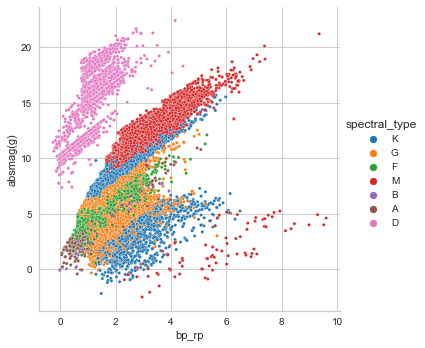

In [52]:
# Diagrama HR só com as classes principais.
sns.relplot(
    data=gaia_model,
    x='bp_rp', y="absmag(g)",
    hue='spectral_type',palette='tab10',s=10
)

Cada classe possui um limite de temperatura, e usei a relação do artigo 'THE REVISED TESS INPUT CATALOG AND CANDIDATE TARGET LIST' e http://astro.if.ufrgs.br/rad/rad/rad.htm, para filtrar os dados.

In [53]:
# Filtragem dos dados pelo limite de temperatura.

g = gaia_model.loc[gaia_model['spectral_type']=='G']
gaia_model = gaia_model.drop(gaia_model.loc[gaia_model['spectral_type']=='G'].index)
g = g.drop(g.loc[g['absmag(g)'] <= 5 ].index)
g = g.drop(g.loc[g['bp_rp'] >= 1.2 ].index)

k = gaia_model.loc[gaia_model['spectral_type']=='K']
gaia_model = gaia_model.drop(gaia_model.loc[gaia_model['spectral_type']=='K'].index)
k = k.drop(k.loc[k['absmag(g)'] <= 6 ].index)
k = k.drop(k.loc[k['bp_rp'] >= 2.5 ].index)

m = gaia_model.loc[gaia_model['spectral_type']=='M']
gaia_model = gaia_model.drop(gaia_model.loc[gaia_model['spectral_type']=='M'].index)
m = m.drop(m.loc[m['absmag(g)'] <= 6 ].index)
m = m.drop(m.loc[m['bp_rp'] <= 2.4 ].index)

f= gaia_model.loc[gaia_model['spectral_type']=='F']
gaia_model = gaia_model.drop(gaia_model.loc[gaia_model['spectral_type']=='F'].index)
f = f.drop(f.loc[f['bp_rp'] >= 0.8 ].index)

a= gaia_model.loc[gaia_model['spectral_type']=='A']
gaia_model = gaia_model.drop(gaia_model.loc[gaia_model['spectral_type']=='A'].index)
a = a.drop(a.loc[a['bp_rp'] >= 0.4 ].index)

b= gaia_model.loc[gaia_model['spectral_type']=='B']
gaia_model = gaia_model.drop(gaia_model.loc[gaia_model['spectral_type']=='B'].index)
b = b.drop(b.loc[b['bp_rp'] >= 0 ].index)

gaia_model = pd.concat([gaia_model, g, k, m, a, b, f], ignore_index=True)


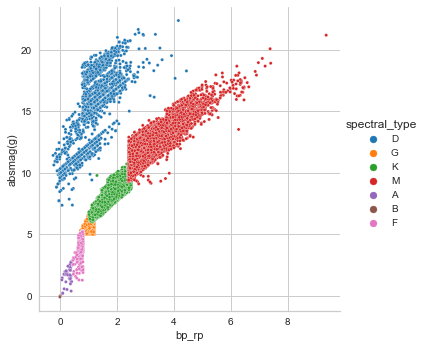

In [54]:
# Diagrama HR dos dados filtrados.

sns.relplot(
    data=gaia_model,
    x='bp_rp', y="absmag(g)",
    hue='spectral_type',palette='tab10',s=10
)


In [55]:
# Analisando a quantidade de estralas por claasse.

gaia_model.groupby('spectral_type').count()

,id,ra,dec,distance,mag_g,mag_bp,mag_rp,teff,logg,feh,luminosity_type,absmag(g),bp_rp
spectral_type,,,,,,,,,,,,,
A,41,41,41,41,41,41,41,41,41,41,41,41,41
B,2,2,2,2,2,2,2,2,2,2,2,2,2
D,1828,1828,1828,1828,1828,1828,1828,1828,1828,1828,1828,1828,1828
F,1021,1021,1021,1021,1021,1021,1021,1021,1021,1021,1021,1021,1021
G,4079,4079,4079,4079,4079,4079,4079,4079,4079,4079,4079,4079,4079
K,13854,13854,13854,13854,13854,13854,13854,13854,13854,13854,13854,13854,13854
M,10653,10653,10653,10653,10653,10653,10653,10653,10653,10653,10653,10653,10653


40 amostras para cada classe é o suficiente, então, vamos filtrar as classes com muitas amostras e adicionar dados para o tipo B.

In [56]:
# Filtrando os dados.

m = gaia_model.loc[gaia_model['spectral_type'] == 'M']
M = m.sample(40)

k = gaia_model.loc[gaia_model['spectral_type'] == 'K']
K = k.sample(40)

g = gaia_model.loc[gaia_model['spectral_type'] == 'G']
G = g.sample(40)

f = gaia_model.loc[gaia_model['spectral_type'] == 'F']
F = f.sample(40)

d = gaia_model.loc[gaia_model['spectral_type'] == 'D']
D = d.sample(40)

a = gaia_model.loc[gaia_model['spectral_type'] == 'A']

b = gaia_model.loc[gaia_model['spectral_type'] == 'B']


downsampling = pd.concat([M, K, G, F, D, a, b], ignore_index=True)
downsampling.groupby('spectral_type').count()

,id,ra,dec,distance,mag_g,mag_bp,mag_rp,teff,logg,feh,luminosity_type,absmag(g),bp_rp
spectral_type,,,,,,,,,,,,,
A,41,41,41,41,41,41,41,41,41,41,41,41,41
B,2,2,2,2,2,2,2,2,2,2,2,2,2
D,40,40,40,40,40,40,40,40,40,40,40,40,40
F,40,40,40,40,40,40,40,40,40,40,40,40,40
G,40,40,40,40,40,40,40,40,40,40,40,40,40
K,40,40,40,40,40,40,40,40,40,40,40,40,40
M,40,40,40,40,40,40,40,40,40,40,40,40,40


In [57]:
# Upsample da classe B.

mask = downsampling.spectral_type == 'B'
sp = downsampling[mask]
sp1 = downsampling[~mask]
upsample = resample(sp, replace = True, n_samples = 42, random_state = 42)
upsample_model = pd.concat([sp1, upsample])



upsample_model.groupby('spectral_type').count()

,id,ra,dec,distance,mag_g,mag_bp,mag_rp,teff,logg,feh,luminosity_type,absmag(g),bp_rp
spectral_type,,,,,,,,,,,,,
A,41,41,41,41,41,41,41,41,41,41,41,41,41
B,42,42,42,42,42,42,42,42,42,42,42,42,42
D,40,40,40,40,40,40,40,40,40,40,40,40,40
F,40,40,40,40,40,40,40,40,40,40,40,40,40
G,40,40,40,40,40,40,40,40,40,40,40,40,40
K,40,40,40,40,40,40,40,40,40,40,40,40,40
M,40,40,40,40,40,40,40,40,40,40,40,40,40


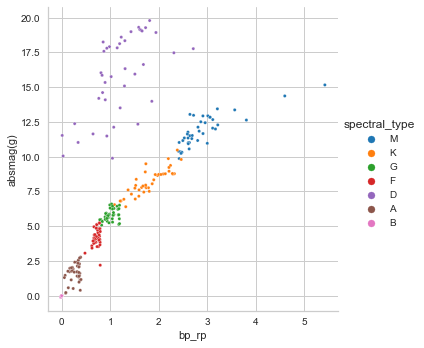

In [58]:
sns.relplot(
    data=upsample_model,
    x='bp_rp', y="absmag(g)",
    hue='spectral_type',palette='tab10',s=10
)


In [60]:
gaia_model = upsample_model

### 3.1.2 - Filtragem

A nossa base de dados possuem observações de baixa qualidade, nessa seção faremos uma filtragem jogando fora esses dados

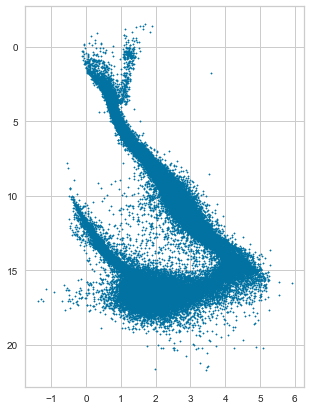

In [61]:
# Plotagem do diagrama HR.
#escrever o que os eixos significam
stars_data['absmag(g)'] = stars_data['mag_g']+5-(5*np.log10(stars_data['distance']))

f, ax = plt.subplots(figsize=(5,7))
plt.scatter(x=stars_data['bp_rp'], y=stars_data['absmag(g)'], s=2)

ax.invert_yaxis()

A qualidade da calibração dos dados é indicada pelo valor do atributo 'phot_proc_mode', quanto menor o valor, melhor a calibração.

In [62]:
# Conferindo a data e a qualidade dos dados.

print(stars_data['phot_proc_mode'].value_counts())

0.0    90423
2.0     5808
1.0     3705
Name: phot_proc_mode, dtype: int64



Os dados tem uma boa calibraçao em quase sua totalidade, mas além do da qualidade da calibração usaremos também os erros na filtragem seguindo os seguintes critérios:

-> phot_proc_mode < 2

-> visibility_periods_used > 8

-> astrometric_excess_noise < 1

-> phot_g_mean_flux_over_error > 50

-> phot_bp_mean_flux_over_error > 20

-> phot_rp_mean_flux_over_error > 20

In [63]:
#Filtrando os dados.

data_filter = stars_data['phot_proc_mode']<2
stars_data = stars_data[data_filter]
data_filter2 = stars_data['visibility_periods_used']>8
stars_data = stars_data[data_filter2]
data_filter3 = stars_data['astrometric_excess_noise']<1
stars_data = stars_data[data_filter3]
data_filter4 = stars_data['phot_g_mean_flux_over_error']>50
stars_data = stars_data[data_filter4]
data_filter5 = stars_data['phot_bp_mean_flux_over_error']>20
stars_data = stars_data[data_filter5]
data_filter6 = stars_data['phot_rp_mean_flux_over_error']>20
stars_data = stars_data[data_filter6]


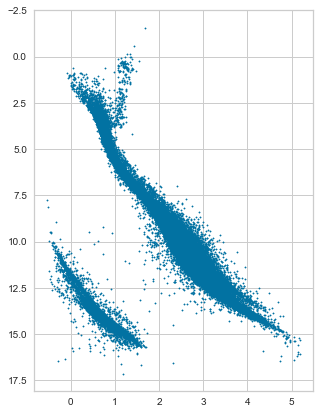

In [64]:
# Plotagem do diagrama HR.
#escrever o que os eixos significam
#stars_data['absmag(g)'] = stars_data['mag_g']+5-(5*np.log10(stars_data['distance']))

f, ax = plt.subplots(figsize=(5,7))
plt.scatter(x=stars_data['bp_rp'], y=stars_data['absmag(g)'], s=2)

ax.invert_yaxis()

A próxima célula serve apenas para reorganizar os índices, já que algumas linhas foram excluídas.

In [67]:
stars_data.to_csv('stars.csv')
stars_data = pd.read_csv('stars.csv')

## 3.2 - Concatenação dos Dataframes.

In [68]:
gaia_model['bp_rp'] = gaia_model['mag_bp'] - gaia_model['mag_rp']
gaia_model['bp_g']  = gaia_model['mag_bp'] - gaia_model['mag_g']
gaia_model['g_rp']  = gaia_model['mag_g'] - gaia_model['mag_rp']

In [69]:
gaia_model['luminosity_type'] = gaia_model['spectral_type'].str[2:]
gaia_model['spectral_type']   = gaia_model['spectral_type'].str[:1]

In [70]:
# Criando um identificador.

stars_data['identificador'] = 0
gaia_model['identificador'] = 1

In [71]:
stars_data = pd.concat([stars_data, gaia_model], ignore_index=True)
stars_data.set_index('id',inplace=True)

In [72]:
# Criando uma cópia dos dados para termos um backup.

stars_data_copy = stars_data

nessa seção falta criar um identificador para cada base de dados e colocar o id como index

## 3.1 - Dados Faltantes.

In [73]:
#Coletando informações sobre a base de dados

stars_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 115119 entries, 5853498713190525696 to 2069553914679656453
Data columns (total 30 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   Unnamed: 0                    60591 non-null   float64
 1   distance                      115119 non-null  float64
 2   ref_epoch                     60591 non-null   float64
 3   ra                            115119 non-null  float64
 4   dec                           115119 non-null  float64
 5   parallax                      60591 non-null   float64
 6   pm                            60591 non-null   float64
 7   astrometric_excess_noise      60591 non-null   float64
 8   nu_eff_used_in_astrometry     56966 non-null   float64
 9   pseudocolour                  3625 non-null    float64
 10  visibility_periods_used       60591 non-null   float64
 11  phot_g_mean_flux_over_error   60591 non-null   float64
 12  mag_g             

Na célula acima vemos que não há nenhum dado categórico, e que existe dados faltantes em algumas colunas. Se somarmos os dados faltantes dos atributos 'nu_eff_used_in_astrometry' e 'pseudocolor', chegamos ao valor total de linhas do dataset, o que sugere que o dado faltante em um pode ser completado com o outro, já que significam a mesma coisa. Estudaremos melhor o caso adiante.

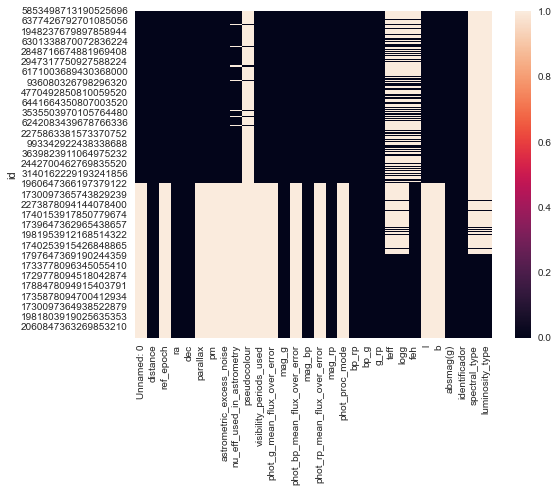

In [74]:
# Mapeando os dados nulos e NAN.

plt.figure(figsize=(8,6))
sns.heatmap(stars_data.isnull())
plt.show()

Nesse mapeamento podemos notar que: 

-> template_teff, template_logg, e template_fe_h, possuem muitos dados faltantes, logo eliminaremos essas colunas. 

-> Os dados nulos da coluna 'nu_eff_used_in_astrometry' serão completados pelos valores de 'pseudocolor', que é o valor estimado.

-> Os dados faltantes dos 'flux_over_error' serão deletados, assim como as medidas de fluxo das respectivas bandas, e os outros dados que dependem deles, como por exemplo: 'bc_rp'. Eles não farão falta, pois, temos uma grande quantidade de dados.



In [75]:
stars_data['spectral_type'].fillna(axis=0, value= -1,inplace=True)
stars_data['luminosity_type'].fillna(axis=0, value= -1,inplace=True)

## 3.3 - Criando Novos Atributos.

As medidas de magnitude(brilho) em sí não faz muito sentido, pois, uma estrela extremamente brilhante que esteja muito longe terá sua medida subestimada em relação a uma estrela pouco brilhante que esteja bem próxima. Logo, precisamos padronizar a medida para que ela reflita as propriedades físicas da estrela, para isso usaremos o módulo de distância que calcula o brilho que a estrela teria a uma distância de 10 parsecs, resolvendo assim nosso problema.

In [76]:
# Aplicando o módulo de distância para padronizar as medidads de magnitude.

stars_data['absmag(g)'] = stars_data['mag_g']+5-(5*np.log10(stars_data['distance']))
stars_data['absmag(r)'] = stars_data['mag_rp']+5-(5*np.log10(stars_data['distance']))
stars_data['absmag(b)'] = stars_data['mag_bp']+5-(5*np.log10(stars_data['distance']))

Assim como a medida de magnitude bruta, as medidas de declinação(dec) e ascenção reta(ra) também não possuem muito significado por sí só, mas combinando com a distância podemos calcular a posição das estrelas em coordenadas esféricas tomando a terra como centro, tornando essa medida mais útil se cada tipo de estrela possuir uma localização preferencial.

In [77]:
stars_data['theta']=1
stars_data.loc[stars_data.dec<0,'theta'] = np.abs(stars_data['dec']) + 90
stars_data.loc[stars_data.dec>0,'theta'] = 90 - np.abs(stars_data['dec']) 
stars_data[['theta','dec']].head(10)

,theta,dec
id,,
5853498713190525696,152.676075,-62.676075
4472832130942575872,85.260580,4.739420
3864972938605115520,82.997273,7.002727
762815470562110464,54.051347,35.948653
4075141768785646848,113.837097,-23.837097
1926461164913660160,45.829624,44.170376
6553614253923452800,125.847164,-35.847164
3796072592206250624,89.200880,0.799120
1872046574983497216,51.243927,38.756073


In [78]:
# Transformando o valor de dec que vai de 90 a -90 graus para o ângulo polar das coordenadas esféricas de 0 a 180 graus.

stars_data['theta']=1
stars_data.loc[stars_data.dec<0,'theta'] = np.abs(stars_data['dec']) + 90
stars_data.loc[stars_data.dec>0,'theta'] = 90 - np.abs(stars_data['dec']) 

# Transformando os ângulos de graus para radianos.

stars_data['theta_rad'] = (stars_data['theta']*np.pi)/180
stars_data['phi_rad'] = (stars_data['ra']*np.pi)/180

# Transfromando de coordenadas esféricas para retângulares (x,y,z).

stars_data['x'] = stars_data['distance']*np.cos(stars_data['phi_rad'])*np.sin(stars_data['theta_rad']);
stars_data['y'] = stars_data['distance']*np.sin(stars_data['phi_rad'])*np.sin(stars_data['theta_rad']);
stars_data['z'] = stars_data['distance']*np.cos(stars_data['theta_rad']);

In [79]:
# Verificando alguns valores manualmente para garantir.

stars_data[['dec', 'theta', 'theta_rad','ra', 'phi_rad','x', 'y', 'z','absmag(g)','absmag(r)','absmag(b)']].head(15) 

,dec,theta,theta_rad,ra,phi_rad,x,y,z,absmag(g),absmag(r),absmag(b)
id,,,,,,,,,,,
5853498713190525696,-62.676075,152.676075,2.664700,217.392321,3.794212,-0.474794,-0.362907,-1.156651,13.411842,11.995628,15.800209
4472832130942575872,4.739420,85.260580,1.488078,269.448503,4.702764,-0.017536,-1.821771,0.151046,11.883967,10.648084,13.481781
3864972938605115520,7.002727,82.997273,1.448576,164.103190,2.864141,-2.298976,0.654742,0.293619,14.129786,12.676845,16.861682
762815470562110464,35.948653,54.051347,0.943374,165.830960,2.894296,-1.998356,0.504513,1.494626,9.521921,8.446262,10.661871
4075141768785646848,-23.837097,113.837097,1.986832,282.458789,4.929836,0.587155,-2.657531,-1.202484,11.758664,10.530397,13.364433
1926461164913660160,44.170376,45.829624,0.799878,355.480015,6.204297,2.258963,-0.178577,2.201320,12.881384,11.519121,15.048535
6553614253923452800,-35.847164,125.847164,2.196447,346.503917,6.047634,2.591380,-0.621948,-1.925375,8.937555,7.907028,10.005314
3796072592206250624,0.799120,89.200880,1.556849,176.937688,3.088145,-3.369075,0.180240,0.047060,11.960132,10.686899,13.720158
1872046574983497216,38.756073,51.243927,0.894375,316.753663,5.528394,1.985875,-1.867885,2.188560,7.732746,6.839013,8.554354


## 3.4 - Organizando a base de dados.

Com os dados devidamente tratados, é hora de eliminar os atributos cujo a única utilidade era a filtragem, os que possuem muitos dados faltantes, e  os que foram criados apenas para calcular atributos mais úteis.

In [80]:
# Eliminando as colunas desnecessárias.

stars_data = stars_data.drop(columns=['ref_epoch','teff','phot_proc_mode','logg', 'nu_eff_used_in_astrometry', 'parallax',
                                      'pm', 'feh', 'pseudocolour', 'phot_g_mean_flux_over_error', 'l', 'b', 'Unnamed: 0',
                                      'phot_bp_mean_flux_over_error','phot_rp_mean_flux_over_error','astrometric_excess_noise',
                                      'visibility_periods_used', 'phi_rad', 'theta_rad', 'theta', 'mag_g',
                                      'mag_rp', 'mag_bp'])

# Eliminando as linhas com dados faltantes.

stars_data.dropna(axis=0, how='any', inplace=True)


In [81]:
stars_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 115119 entries, 5853498713190525696 to 2069553914679656453
Data columns (total 15 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   distance         115119 non-null  float64
 1   ra               115119 non-null  float64
 2   dec              115119 non-null  float64
 3   bp_rp            115119 non-null  float64
 4   bp_g             115119 non-null  float64
 5   g_rp             115119 non-null  float64
 6   absmag(g)        115119 non-null  float64
 7   identificador    115119 non-null  int64  
 8   spectral_type    115119 non-null  object 
 9   luminosity_type  115119 non-null  object 
 10  absmag(r)        115119 non-null  float64
 11  absmag(b)        115119 non-null  float64
 12  x                115119 non-null  float64
 13  y                115119 non-null  float64
 14  z                115119 non-null  float64
dtypes: float64(12), int64(1), object(2)
memory usage: 14.1+ MB


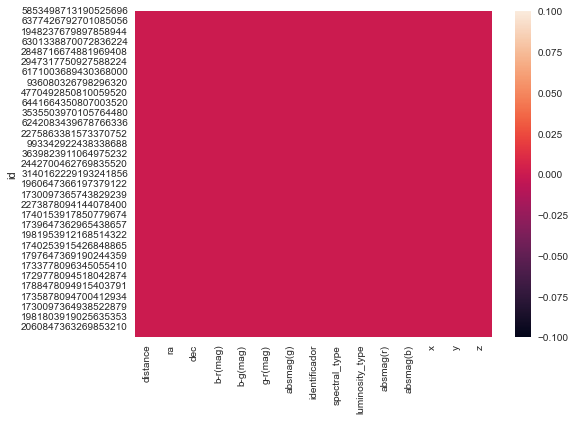

In [82]:
# Renomeando as colunas para ficar mais intuitivo .

stars_data = stars_data.rename(columns={'nu_eff_used_in_astrometry': 'freq_eff','bp_rp': 'b-r(mag)',
                                        'bp_g': 'b-g(mag)','g_rp': 'g-r(mag)'})

# Verificando se o dataframe está completo.

plt.figure(figsize=(8,6))
sns.heatmap(stars_data.isnull())
plt.show()

**Agora não temos nenhum dado faltante!**

# 04 - Análise exploratória.

## 4.1 - Estatística descritiva.

In [83]:
# Estatística descritiva.

describe = stars_data.drop(columns=['spectral_type'])
describe = describe.describe().T
describe['kurtose'] = stars_data.kurtosis()
describe['viés']= stars_data.skew()
describe.round(2)

C:\Users\Diego\AppData\Local\Temp/ipykernel_7620/3559014201.py:5: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  describe['kurtose'] = stars_data.kurtosis()
C:\Users\Diego\AppData\Local\Temp/ipykernel_7620/3559014201.py:6: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  describe['viés']= stars_data.skew()


,count,mean,std,min,25%,50%,75%,max,kurtose,viés
distance,115119.0,2645.46,3517.05,1.30,47.71,60.54,4784.42,40848.14,2.81,1.48
ra,115119.0,212.67,94.24,0.01,150.15,248.99,281.89,359.99,-0.60,-0.69
dec,115119.0,-9.23,38.25,-89.14,-36.94,-13.80,21.19,89.58,-0.80,0.30
b-r(mag),115119.0,2.10,0.90,-0.54,1.37,2.11,2.78,10.76,-0.06,0.20
b-g(mag),115119.0,1.11,0.62,-3.61,0.60,1.05,1.55,8.95,1.10,0.64
g-r(mag),115119.0,0.99,0.30,-0.36,0.77,1.05,1.23,4.27,0.25,-0.54
absmag(g),115119.0,8.95,3.13,-2.07,6.33,9.05,11.39,22.38,-0.48,0.05
identificador,115119.0,0.47,0.50,0.00,0.00,0.00,1.00,1.00,-1.99,0.11
absmag(r),115119.0,7.96,2.97,-3.61,5.54,7.97,10.16,20.90,-0.16,0.16
absmag(b),115119.0,10.06,3.57,-0.84,7.03,10.16,12.93,28.76,-0.76,0.03


Os resultados que mais chamam a atenção por enquanto é o viés e a kurtose muito maior na parallax em comparação com os outros.

## 4.2 - Histogramas.

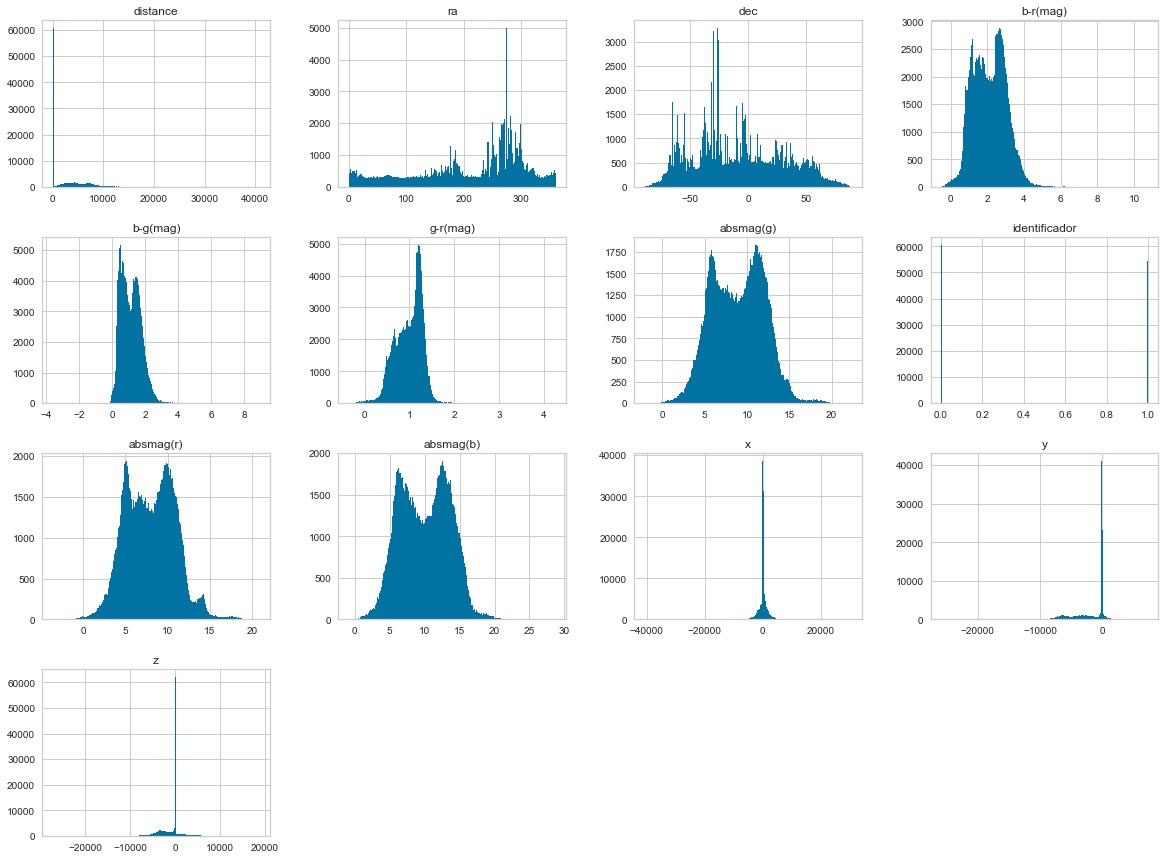

In [84]:
%matplotlib inline
stars_data.hist(figsize=(20,15), bins=200)
plt.show()

Pelos histogramas percebe-se que os atributos l, ra, e unamed são quase constantes, não trazendo quase nenhuma informação para o modelo.

## 4.3 -  Correlação.

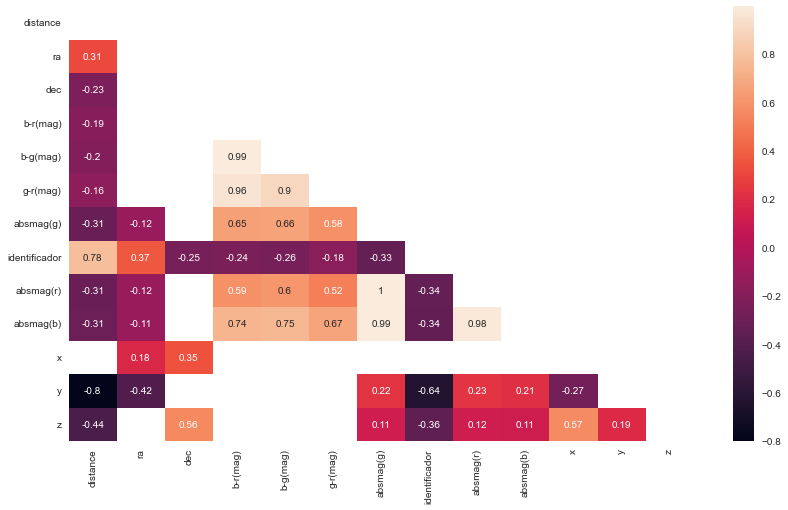

In [85]:
%matplotlib inline
plt.figure(figsize=(14, 8))
corr=stars_data.corr()
mask = np.triu(np.ones_like(corr, dtype=bool));
sns.heatmap(corr[(corr > .1) | (corr < -.1)], annot = True, mask = mask);
#sns.heatmap(full_dataset.corr(),vmin = -1, vmax = +1, annot = True)
plt.show()

No gráfico acima algumas temos algumas correlações importantes, são elas:

-> Alta correlação negativa entre freq_eff e a deferenças de magnitude;

-> Alta correlação entre os valores de magnitude absoluta;

-> Esperada alta correlação entre parallax e distância, já que o segundo atributo é calculado através do primeiro;

-> Alta correlação dec-z e ra-y, mesmo caso acima.

Provavelmente só será necessário manter apenas um atributo de cada tópico acima.

## 4.4 - Boxplots.

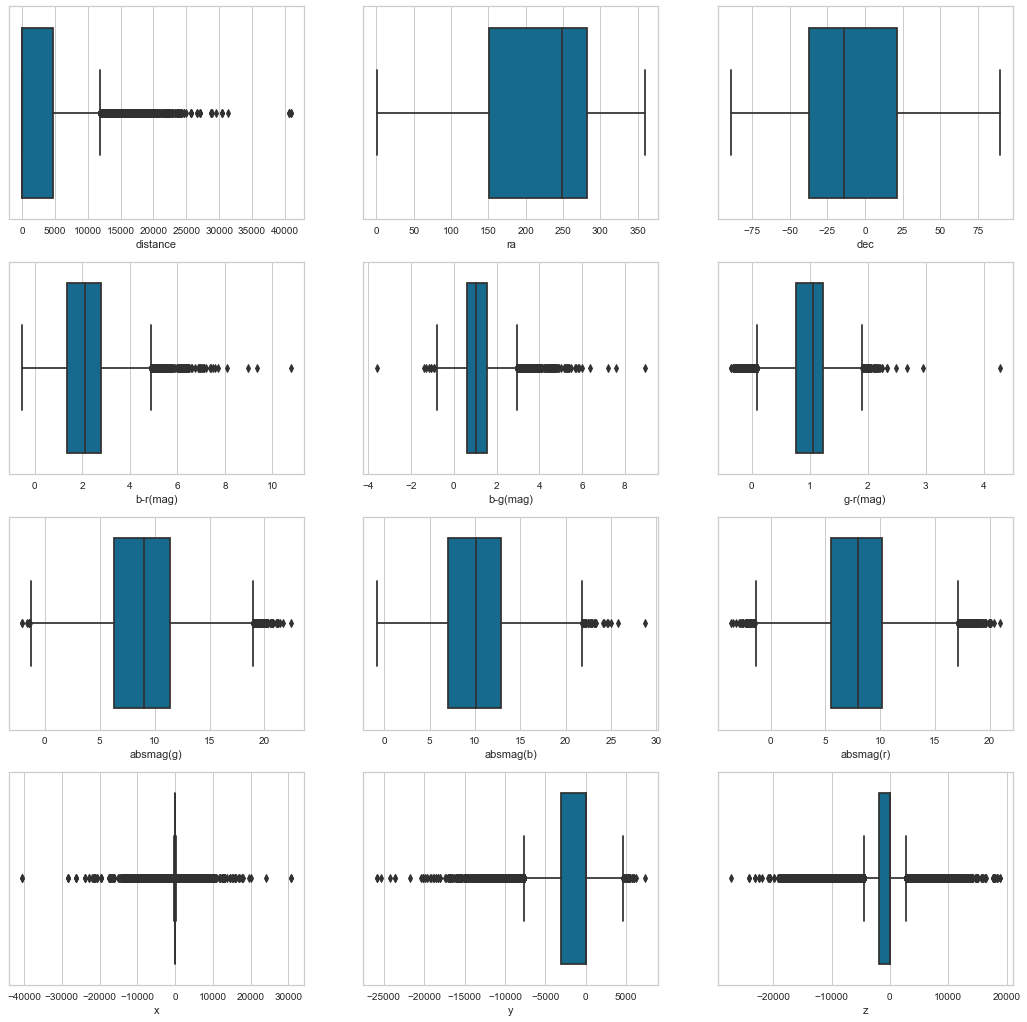

In [86]:
fig, axis = plt.subplots(4,3, figsize = (18,18))

sns.boxplot(data = stars_data, x = 'distance', ax = axis[0,0]);
sns.boxplot(data = stars_data, x = 'ra', ax = axis[0,1]);
sns.boxplot(data = stars_data, x = 'dec', ax = axis[0,2]);

sns.boxplot(data = stars_data, x = 'b-r(mag)', ax = axis[1,0]);
sns.boxplot(data = stars_data, x = 'b-g(mag)', ax = axis[1,1]);
sns.boxplot(data = stars_data, x = 'g-r(mag)', ax = axis[1,2]);

sns.boxplot(data = stars_data, x = 'absmag(g)', ax = axis[2,0]);
sns.boxplot(data = stars_data, x = 'absmag(b)', ax = axis[2,1]);
sns.boxplot(data = stars_data, x = 'absmag(r)', ax = axis[2,2]);

sns.boxplot(data = stars_data, x = 'x', ax = axis[3,0]);
sns.boxplot(data = stars_data, x = 'y', ax = axis[3,1]);
sns.boxplot(data = stars_data, x = 'z', ax = axis[3,2]);

Alguns atributos possuem bastante outliers, o que vai influir na padronização.

------------------------------------------------------------------------------------------------------------------------------

# 05 - Preparação dos dados para o modelo.

## 5.1 - Criação dos Dataframes para o modelo.

In [87]:
# Criando um Dataframe para guardar as coordenadas.

coo = pd.DataFrame()

coo['x'] = stars_data['x']
coo['y'] = stars_data['y']
coo['z'] = stars_data['z']
coo['distance'] = stars_data['distance']

In [88]:
# Criando um Dataframe para o modelo.

heatmap_dependence = stars_data.drop(columns=['spectral_type', 'luminosity_type'])

Para a seleção dos melhores atributos vamos usar a biblioteca rfpimp que faz o treinamento de uma floresta aleatória para cada atributo tentando prever o outro, para assim verificar se ahá dados colineares.

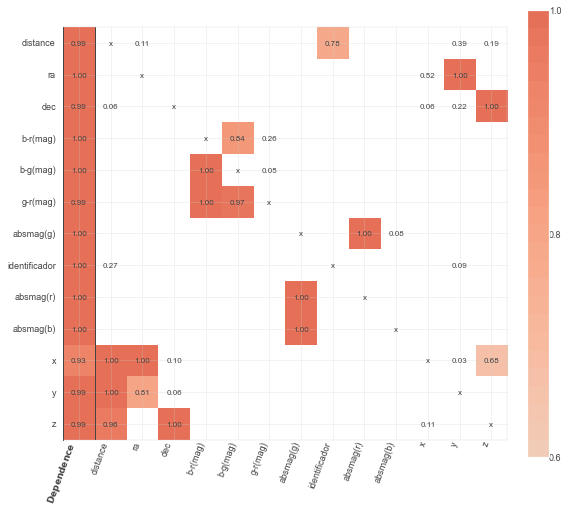

In [89]:
rfpimp.plot_dependence_heatmap(rfpimp.feature_dependence_matrix(heatmap_dependence),figsize=(8,8))
fig = plt.gcf()

In [91]:
stars_data.groupby('spectral_type').count()

,distance,ra,dec,b-r(mag),b-g(mag),g-r(mag),absmag(g),identificador,luminosity_type,absmag(r),absmag(b),x,y,z
spectral_type,,,,,,,,,,,,,,
-1,83641,83641,83641,83641,83641,83641,83641,83641,83641,83641,83641,83641,83641,83641
A,41,41,41,41,41,41,41,41,41,41,41,41,41,41
B,2,2,2,2,2,2,2,2,2,2,2,2,2,2
D,1828,1828,1828,1828,1828,1828,1828,1828,1828,1828,1828,1828,1828,1828
F,1021,1021,1021,1021,1021,1021,1021,1021,1021,1021,1021,1021,1021,1021
G,4079,4079,4079,4079,4079,4079,4079,4079,4079,4079,4079,4079,4079,4079
K,13854,13854,13854,13854,13854,13854,13854,13854,13854,13854,13854,13854,13854,13854
M,10653,10653,10653,10653,10653,10653,10653,10653,10653,10653,10653,10653,10653,10653


In [ ]:
mask = stars_data

O resultado do rfpimp nos mostra que com a 'parallax' é possível prever a distância, o atributo b-r(mag) prevê g-r, b-g, e freq_eff, e com absmag(g) é possível prever os outros valores de absmag, assim como esperado pela pontuação da correlação. Outra informação é que o atributo b deduz as coordenadas, mas decidi mantê-las mesmo assim, pois, elas trazem consigo as informações espaciais de forma mais completa.

Logo, criarei um Dataframe tirando os atributos correlacionados e outro completo com a finalidade de ter certeza do melhor dataset.

In [537]:
df_model = stars_data
df_model = df_model.drop(columns=['ra', 'dec', 'b-g(mag)', 'g-r(mag)', 'absmag(r)', 'absmag(b)','x','y','z', 'luminosity_type',
                                  'distance'])

In [538]:
X = df_model.drop(columns = ['spectral_type', 'identificador'])
Y = df_model.drop(columns = ['b-r(mag)', 'absmag(g)', 'identificador'])

## 5.2 - Padronização.

In [539]:
# Verificando 
for col in X:
    stat, p = normaltest(X[col])
    print('stat: %.3f, p: %.3f' %(stat, p))
    if p > 0.05:
        print('{}: Probably Gaussian\n'.format(col))
    else:
        print('{}: Probably Not Gaussian\n'.format(col))

stat: 758.817, p: 0.000
b-r(mag): Probably Not Gaussian

stat: 2025.853, p: 0.000
absmag(g): Probably Not Gaussian



In [540]:
mms = MinMaxScaler()
rs = RobustScaler()

In [541]:
# MinMaxScaler 
#df_model['b'] = mms.fit_transform(df_model[['b']].values)
#df_model['x'] = mms.fit_transform(df_model[['x']].values)
#df_model['y'] = mms.fit_transform(df_model[['y']].values)
#df_model['z'] = mms.fit_transform(df_model[['z']].values)


# RobustScaler
#X['distance'] = rs.fit_transform(X[['distance']].values)
#df_model['pm'] = rs.fit_transform(df_model[['pm']].values)
#df_model['freq_eff'] = rs.fit_transform(df_model[['freq_eff']].values)
X['b-r(mag)'] = rs.fit_transform(X[['b-r(mag)']].values)
#df_model['b-g(mag)'] = rs.fit_transform(df_model[['b-g(mag)']].values)
#df_model['g-r(mag)'] = rs.fit_transform(df_model[['g-r(mag)']].values)
X['absmag(g)'] = rs.fit_transform(X[['absmag(g)']].values)
#df_model['absmag(r)'] = rs.fit_transform(df_model[['absmag(r)']].values)
#df_model['absmag(b)'] = rs.fit_transform(df_model[['absmag(b)']].values)
#df_model['parallax'] = rs.fit_transform(df_model[['parallax']].values)


In [542]:
X = X - X.mean()
X = X/X.std()

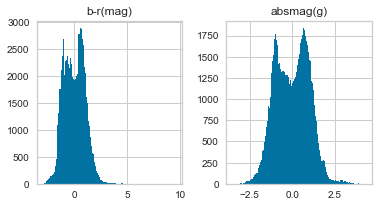

In [543]:
%matplotlib inline
X.hist(figsize=(6,3), bins=200)
plt.show()

In [544]:
X.std()

b-r(mag)     1.0
absmag(g)    1.0
dtype: float64

In [545]:
X.mean()

b-r(mag)    -8.201526e-16
absmag(g)   -2.393558e-16
dtype: float64

## 0.5 - Modelo.

In [546]:
from sklearn.semi_supervised import LabelPropagation
from sklearn.semi_supervised import LabelSpreading

In [460]:
Y

,spectral_type
id,
5853498713190525696,-1
4472832130942575872,-1
3864972938605115520,-1
762815470562110464,-1
4075141768785646848,-1
...,...
1967247368352956417,F
1967397365790801921,F
1816803915333632005,F


In [557]:
Y.loc[Y['spectral_type']=='M'] = 0
Y.loc[Y['spectral_type']=='K'] = 1
Y.loc[Y['spectral_type']=='G'] = 2
Y.loc[Y['spectral_type']=='F'] = 3
Y.loc[Y['spectral_type']=='A'] = 4
Y.loc[Y['spectral_type']=='B'] = 5
Y.loc[Y['spectral_type']=='D'] = 6

Y['spectral_type'] = Y['spectral_type'].astype(int)

In [560]:
Y

,spectral_type
id,
5853498713190525696,-1
4472832130942575872,-1
3864972938605115520,-1
762815470562110464,-1
4075141768785646848,-1
...,...
1967247368352956417,3
1967397365790801921,3
1816803915333632005,3


In [561]:

lp_model = LabelSpreading(gamma=0.25, max_iter=20)
lp_model.fit(X, Y.values.ravel())


MemoryError: Unable to allocate 98.7 GiB for an array with shape (115119, 115119) and data type float64